In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# 导入数据
name1 = ['userID', 'date', 'Det', 'Dem', 'Income']
name2 = ['userID', 'date', 'bankID', 'n_bill', 'n_refund', 
         'credit_limit', 'bill_balance', 'min_repay', 'pay', 
         'bill','adjust', 'circ_instant', 'usabl_balance', 'imp_cash', 'repay']
name3 = ['userID', 'date', 'behav_data', 'behav_s_num']
name4 = ['userID', 'loan_date']
name5 = ['userID', 'sex', 'job', 'education', 'marriage', 'RPR']
name6 = ['userID', 'label']

bank_data = pd.read_csv('data/bank_detail_train.txt', names=name1)
bill_data = pd.read_csv('data/bill_detail_train.txt', names=name2)
browse_data = pd.read_csv('data/browse_history_train.txt', names=name3)
loan_data = pd.read_csv('data/loan_time_train.txt', names=name4)
user_data = pd.read_csv('data/user_info_train.txt', names=name5)
train_label = pd.read_csv('data/overdue_train.txt', names=name6)
bank_data.head()

,userID,date,Det,Dem,Income
0,6965,5894316387,0,13.756664,0
1,6965,5894321388,1,13.756664,0
2,6965,5897553564,0,14.449810,0
3,6965,5897563463,1,10.527763,0
4,6965,5897564598,1,13.651303,0


- 1. user_data是用户的基本信息，其中性别为0表示未知
- 2. bank_data是银行流水，时间戳为0不表示未知， 交易类型1表示支出，0表示收入， 工资收入为1表示工资收入
- 3. browse_data是用户浏览行为，时间戳为0表示未知
- 4. bill_data是信用卡账单记录，时间戳为0表示未知
- 5. loan_data是放款时间
- 6. train_label是顾客是否发生逾期行为记录，1表示逾期30天以上， 0表示逾期10天以内
- 由于用户性别有未知项，先对未知项进行处理，因为性别是二分类数据，所以用众数对未知项进行修改
- 有时间特征的表分别是：bank_data, browse_data, bill_data, loan_data, 其中bank_data, browse_data和bill_data有时间未知项
- 判断是否发生逾期，通过对放款后的情况进行判断，故需要对未知时间进行处理。
- 由于未知时间无法确定，故用对应用户ID的放款时间进行修改

In [3]:
print(len(bank_data['userID'].unique()), 
      len(bill_data['userID'].unique()), 
      len(browse_data['userID'].unique()), 
      len(loan_data['userID'].unique()), 
      len(user_data['userID'].unique()), 
      len(train_label['userID'].unique()))

9294 53174 47330 55596 55596 55596


In [4]:
# 计算性别的众数
mode_ = user_data[user_data['sex'] != 0]['sex'].mode()
mode_ = mode_[0]
mode_

1

In [5]:
user_data.replace({'sex': 0}, {'sex': mode_}, inplace=True)

In [6]:
user_data['sex'].unique()

array([1, 2])

In [7]:
# 对银行流水、用户浏览行为、行信用卡账单记录的未知时间戳进行补全
# 银行流水
bank_data = pd.merge(bank_data, loan_data, how='inner', on='userID')
bank_data.loc[bank_data['date'] == 0,'date'] = bank_data[bank_data['date'] == 0]['loan_date'].values
bank_id = bank_data[bank_data['date'] >= bank_data['loan_date']]
bank_id = bank_id['userID']
bank_id.drop_duplicates(keep='first', inplace=True)

/Users/yangsan/opt/anaconda3/envs/ys/lib/python3.7/site-packages/pandas/core/base.py:1629: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [8]:
browse_data = pd.merge(browse_data, loan_data, how='inner', on='userID')
browse_data.loc[browse_data['date'] == 0, 'date'] = browse_data[browse_data['date'] == 0]['loan_date'].values
browse_id = browse_data[browse_data['date'] >= browse_data['loan_date']]
browse_id = browse_id['userID']
browse_id.drop_duplicates(keep='first', inplace=True)

In [9]:
bill_data = pd.merge(bill_data, loan_data, how='inner', on='userID')
bill_data.loc[bill_data['date'] == 0, 'date'] = bill_data[bill_data['date'] == 0]['loan_date'].values
bill_id = bill_data[bill_data['date'] >= bill_data['loan_date']]
bill_id = bill_id['userID']
bill_id.drop_duplicates(keep='first', inplace=True)

- 根据贷款人放贷后的表现行为，预测用户未来是否逾期
- 通过放款时间过滤掉放款前的数据

In [10]:
bank_data = bank_data[bank_data['date'] >= bank_data['loan_date']]
browse_data = browse_data[browse_data['date'] >= browse_data['loan_date']]
bill_data = bill_data[bill_data['date'] >= bill_data['loan_date']]
len(bank_data['userID'].unique())

4190

In [11]:
income = bank_data[bank_data['Det'] == 1].groupby(by='userID', as_index=False)
exp = bank_data[bank_data['Det'] == 0].groupby(by='userID', as_index=False)
wage = bank_data[bank_data['Income'] == 1].groupby(by='userID', as_index=False)
income.head()

,userID,date,Det,Dem,Income,loan_date
363,6965,5923871668,1,12.147230,0,5923841487
778,1265,5915922791,1,14.519336,0,5915892687
779,1265,5915926530,1,13.063517,0,5915892687
780,1265,5915933441,1,13.081750,0,5915892687
782,1265,5915939695,1,11.097418,0,5915892687
...,...,...,...,...,...,...
6069662,15286,5926519887,1,6.945181,0,5926519887
6069664,15286,5926519887,1,13.756664,0,5926519887
6069666,15286,5926606287,1,12.619791,0,5926519887
6069667,15286,5926606287,1,11.230947,0,5926519887


In [12]:
i = income['Dem'].agg({'Income_sum': 'sum', 'Income_mun': 'count'}) # 统计支出
e = exp['Dem'].agg({'exp_sum': 'sum', 'exp_mun': 'count'}) # 统计收入
w = wage['Dem']. agg({'wage_sum': 'sum', 'wage_mun': 'count'}) # 统计工资
i.head()

,userID,Income_sum,Income_mun
0,10,981.631241,77
1,25,1424.191949,154
2,29,3558.584606,331
3,33,4154.503189,382
4,36,7611.381494,588


In [13]:
bank = pd.merge(i, e, how='left', on='userID')
bank = pd.merge(bank, w, how='left', on='userID')
bank.shape

(3169, 7)

In [14]:
bank.isnull().mean()

userID        0.000000
Income_sum    0.000000
Income_mun    0.000000
exp_sum       0.121174
exp_mun       0.121174
wage_sum      0.841906
wage_mun      0.841906
dtype: float64

In [15]:
bank_ = i.merge(e)
bank_ = bank_.merge(w)
bank_.head()

,userID,Income_sum,Income_mun,exp_sum,exp_mun,wage_sum,wage_mun
0,38,1490.461572,140,656.141099,60,9.844693,1
1,44,265.787155,19,212.864727,15,90.865105,6
2,67,4891.912261,433,2588.600830,215,72.647045,6
3,97,2247.120729,186,2392.309750,195,55.026656,4
4,104,4202.456197,364,2305.532901,173,44.267343,3


In [16]:
bill = bill_data.drop(['bankID', 'date', 'loan_date'], axis=1)
bill.head()

,userID,n_bill,n_refund,credit_limit,bill_balance,min_repay,pay,bill,adjust,circ_instant,usabl_balance,imp_cash,repay
7,3150,0.000000,0.000000,0.000000,16.851878,16.207495,0,0.000000,0.000000,0.0,0.0,0.000000,0
8,3150,19.237914,19.420133,19.460445,-16.292183,14.327077,1,17.322724,0.000000,0.0,0.0,19.460445,0
9,3150,19.754017,19.355084,21.580708,19.971764,19.420654,0,19.976445,18.659787,0.0,0.0,21.580708,0
10,3150,19.904695,18.831836,21.000890,20.189107,18.875165,3,0.000000,0.000000,0.0,0.0,20.307743,0
11,3150,19.290633,19.290633,19.460445,19.237914,16.242236,1,19.237914,0.000000,0.0,0.0,19.460445,0


In [17]:
# 本期账单金额 = 上期账单金额 - 上期还款金额 + 本期账单金额 - 本期调整金额 + 循环利息
bill['refund'] = bill['n_bill'] - bill['n_refund'] + bill['bill'] - bill['adjust'] + bill['circ_instant'] # 本期还款金额
refund = bill[['userID', 'refund']].groupby('userID', as_index=False).sum()
refund.head()

,userID,refund
0,2,224.272942
1,3,36.736017
2,4,148.355345
3,5,40.193445
4,6,375.735111


In [18]:
# 本月还款率
n_refund = bill[['userID', 'n_refund']].groupby('userID', as_index=False).sum()
rate = pd.merge(n_refund, refund, how='inner', on='userID')
rate['rate'] = rate['refund'] / rate['n_refund']
rate.drop(['n_refund', 'refund'], axis=1, inplace=True)
rate.head()

,userID,rate
0,2,1.038394
1,3,0.988581
2,4,2.032123
3,5,1.083980
4,6,0.853994


In [19]:
limit_rate = bill[['userID', 'credit_limit', 'bill']].groupby('userID', as_index=False)
limit_ = limit_rate['credit_limit', 'bill'].agg(np.sum)
limit_['limit_rate'] = limit_['bill'] / limit_['credit_limit'] # 额度使用率
limit_.drop(['credit_limit', 'bill'], axis=1, inplace=True)
limit_.head()

,userID,limit_rate
0,2,0.747516
1,3,1.011958
2,4,0.436306
3,5,0.868994
4,6,0.599908


In [20]:
bill_ = refund.merge(rate)
bill_ = bill_.merge(limit_)
bill_.head()

,userID,refund,rate,limit_rate
0,2,224.272942,1.038394,0.747516
1,3,36.736017,0.988581,1.011958
2,4,148.355345,2.032123,0.436306
3,5,40.193445,1.083980,0.868994
4,6,375.735111,0.853994,0.599908


In [21]:
# 对inf数据进行缺失值替换
bill_.replace([np.inf, -np.inf], np.nan, inplace=True)
bill_[bill_.values == np.isinf]

,userID,refund,rate,limit_rate


In [22]:
bill_.isnull().mean()

userID        0.000000
refund        0.000000
rate          0.131409
limit_rate    0.073145
dtype: float64

In [23]:
bill_.shape

(41329, 4)

In [24]:
browse_ = browse_data.groupby(by='userID', as_index=False)
browse_ = browse_['behav_data'].agg({'behav_data': 'count'})
browse_.shape

(12171, 2)

- 通过userID连接有所有表生成有完整字段的新表

In [25]:
train = pd.merge(user_data, train_label, how='left', on='userID')
train = pd.merge(train, bill_, how='left', on='userID')
train = pd.merge(train, browse_, how='left', on='userID')
train = pd.merge(train, bank, how='left', on='userID')
train.head()

,userID,sex,job,education,marriage,RPR,label,refund,rate,limit_rate,behav_data,Income_sum,Income_mun,exp_sum,exp_mun,wage_sum,wage_mun
0,3150,1,2,4,1,4,0,168.413009,0.450642,0.650708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6965,1,2,4,3,2,0,126.460960,2.482897,0.942609,NaN,12.147230,1.0,NaN,NaN,NaN,NaN
2,1265,1,3,4,3,1,0,1496.170370,1.952343,0.951631,NaN,51.762021,4.0,13.063517,1.0,NaN,NaN
3,6360,1,2,4,3,2,0,1239.106439,1.586593,0.741511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2583,2,2,2,1,1,0,566.497631,1.546226,0.939478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55596 entries, 0 to 55595
Data columns (total 17 columns):
userID        55596 non-null int64
sex           55596 non-null int64
job           55596 non-null int64
education     55596 non-null int64
marriage      55596 non-null int64
RPR           55596 non-null int64
label         55596 non-null int64
refund        41329 non-null float64
rate          35898 non-null float64
limit_rate    38306 non-null float64
behav_data    12171 non-null float64
Income_sum    3169 non-null float64
Income_mun    3169 non-null float64
exp_sum       2785 non-null float64
exp_mun       2785 non-null float64
wage_sum      501 non-null float64
wage_mun      501 non-null float64
dtypes: float64(10), int64(7)
memory usage: 7.6 MB


In [27]:
# 平衡数据样本
train['label'].value_counts()

0    48413
1     7183
Name: label, dtype: int64

In [28]:
label_0 = train[train['label'] == 0].sample(7183, random_state=420)
label_1 = train[train['label'] == 1]
train_data = pd.concat([label_0, label_1])

In [29]:
new_data = train_data.sample(frac=1, random_state=42)
new_data.head()

,userID,sex,job,education,marriage,RPR,label,refund,rate,limit_rate,behav_data,Income_sum,Income_mun,exp_sum,exp_mun,wage_sum,wage_mun
36490,38971,1,4,2,3,4,1,19.05498,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13351,13845,1,4,4,3,2,1,0.00000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18341,19810,1,2,4,3,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53952,53452,1,2,3,1,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34318,10639,1,4,4,1,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


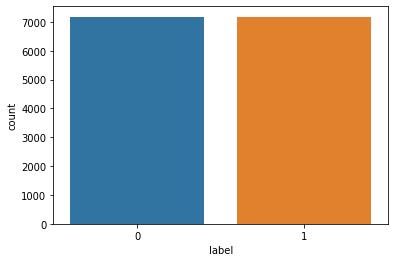

In [30]:
sns.countplot(new_data.label)

####  缺失值处理
- 采用多重差补的方法对缺失值进行处理

In [31]:
from statsmodels.imputation import mice
notna_data = new_data.copy()
imp = mice.MICEData(notna_data)
# 指定数据
imp.update_all(20)

In [32]:
new_ = imp.data
new_.isnull().mean()

userID        0.0
sex           0.0
job           0.0
education     0.0
marriage      0.0
RPR           0.0
label         0.0
refund        0.0
rate          0.0
limit_rate    0.0
behav_data    0.0
Income_sum    0.0
Income_mun    0.0
exp_sum       0.0
exp_mun       0.0
wage_sum      0.0
wage_mun      0.0
dtype: float64

#### 对每个特征进行分箱
- 对每个x生成一个对象;记录IV值;生成WOE图

In [33]:
def Segmen(data, y, x, p = 0.1, max_deep = 15, plot = True):
    X = np.array(data[x][data[x].notna()]).reshape(-1,1)
    y = data[y][data[x].notna()]
    
    # 调参，得到最优的叶节点比例
    gini_impure = np.linspace(0, 0.00015, 50)
    param = {'min_impurity_decrease': gini_impure}
    GS = GridSearchCV(DecisionTreeClassifier(), param_grid=param, cv=5, iid=False)
    GS.fit(X, y)
    
    # 使用最优树结构模型
    dtc = DecisionTreeClassifier(max_leaf_nodes=max_deep, min_samples_leaf=p, 
                             min_impurity_decrease=GS.best_params_['min_impurity_decrease'])
    dtc.fit(X, y)
    
    # 找到节点阈值
    th = dtc.tree_.threshold[dtc.tree_.children_left != dtc.tree_.children_right]
    
    # 计算最优分割点
    cp = np.append(th, np.array([X.max(), X.min()]))
    cp.sort()
    
    woe = WOE_Map(data, y, x, cutpoints = cp, plot = plot)
    return woe

In [34]:
def WOE_Map(data, y, x, cutpoints = None, category = False, plot = True):
    if category:
        bins = data[x].astype('category')
    else:
        bins = pd.cut(data[x], cutpoints, include_lowest=True)
    cutrec = bins.value_counts(dropna=False, sort=False)
    IVtable = pd.DataFrame({'Bins': cutrec.index.astype(str), 'CntRec': cutrec.values})
    IVtable["CntGood"] = bins[data['label']==0].value_counts(dropna=False,sort=False).values
    IVtable["CntBad"] = bins[data['label']==1].value_counts(dropna=False,sort=False).values
    IVtable = IVtable.append(IVtable.sum(axis=0),ignore_index=True)
    IVtable.iloc[-1,0] = "Total"
    IVtable["PctRec"] = IVtable["CntRec"]/IVtable["CntRec"].iloc[-1]
    IVtable["PctGood"] = IVtable["CntGood"]/IVtable["CntGood"].iloc[-1]
    IVtable["PctBad"] = IVtable["CntBad"]/IVtable["CntBad"].iloc[-1]
    IVtable["WOE"] = np.log(IVtable["PctGood"]/IVtable["PctBad"]).round(4)
    IVtable["IV"] = ((IVtable["PctGood"] - IVtable["PctBad"])*IVtable["WOE"]).round(4)
    IVtable["WOE"].iat[-1] = np.nan 
    IVtable["IV"].iat[-1] = IVtable["IV"].iloc[:-1].sum()
    
    IV = IVtable['IV'].iloc[-1]
    
    Xname = x
    Dict = dict(zip(IVtable["Bins"].iloc[:-1],IVtable["WOE"].iloc[:-1]))
    if plot:
        pd.DataFrame(Dict,index=["WOE"]).T.plot(kind="bar",figsize=(16,10))
        plt.show()
    
    if category:
        cutpoints = np.array(IVtable['Bins'][:-1])
        
    out = pd.Series({"IVtable":IVtable,"IV":IV,"Xname":Xname,"Dict":Dict,
                     "Xbin":bins,"Cutpoints":np.array(cutpoints)})
    return out

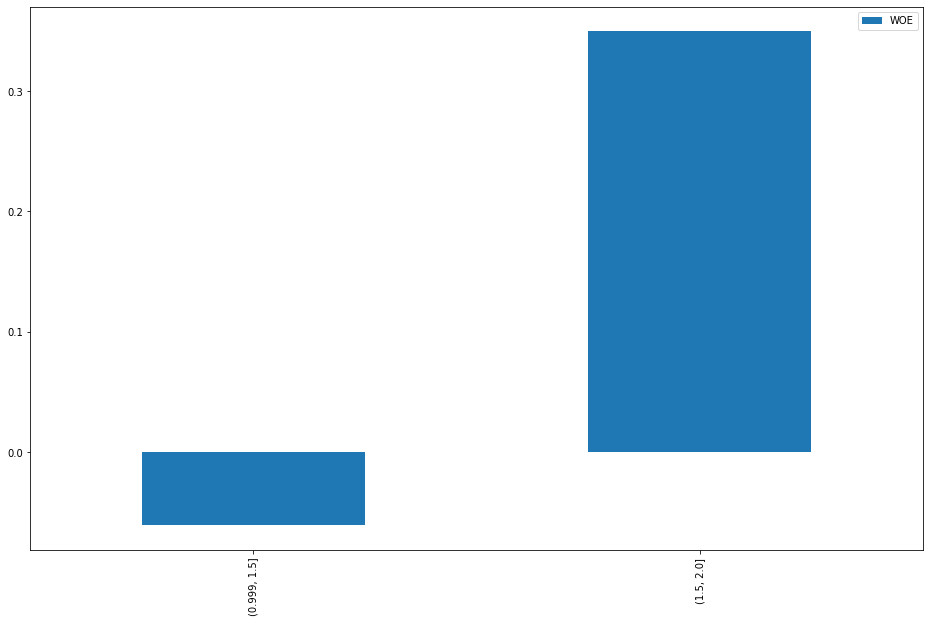

In [35]:
sex_1 = Segmen(new_, 'label', 'sex')

In [36]:
sex_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(0.999, 1.5]",12211,5919,6292,0.849993,0.824029,0.875957,-0.0611,0.0032
1,"(1.5, 2.0]",2155,1264,891,0.150007,0.175971,0.124043,0.3497,0.0182
2,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0214


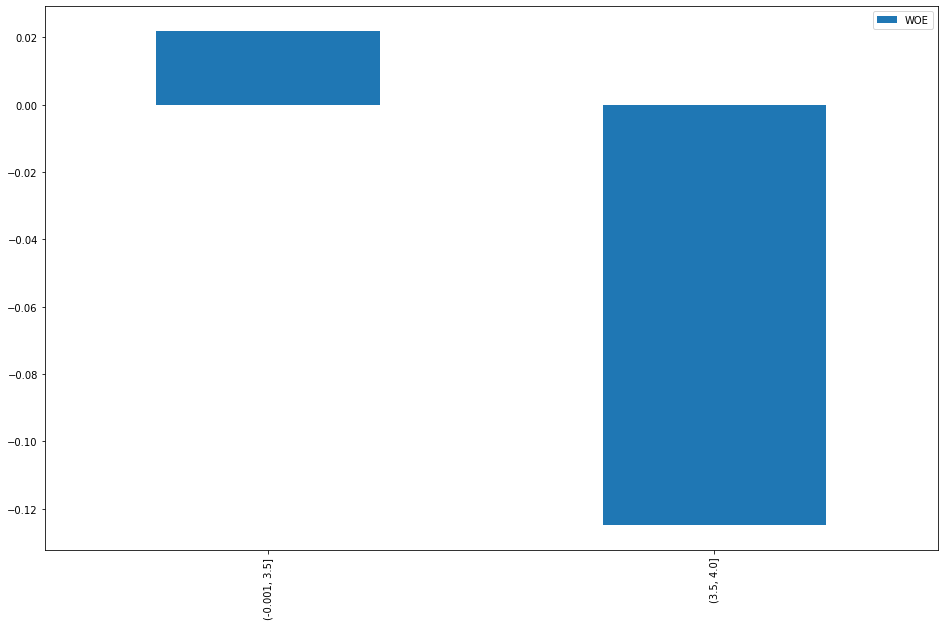

In [84]:
job_1 = Segmen(new_, 'label', 'job')

In [85]:
job_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 3.5]",12218,6176,6042,0.85048,0.859808,0.841153,0.0219,0.0004
1,"(3.5, 4.0]",2148,1007,1141,0.14952,0.140192,0.158847,-0.1249,0.0023
2,Total,14366,7183,7183,1.00000,1.000000,1.000000,NaN,0.0027


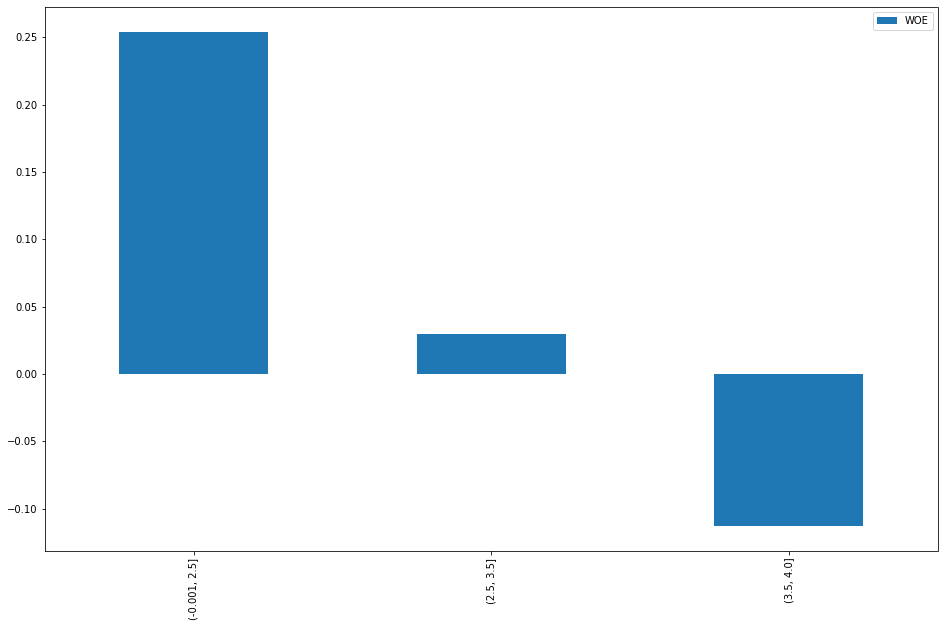

In [39]:
edu_1 = Segmen(new_, 'label', 'education')

In [40]:
edu_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 2.5]",2074,1168,906,0.144369,0.162606,0.126131,0.2540,0.0093
1,"(2.5, 3.5]",6044,3067,2977,0.420716,0.426980,0.414451,0.0298,0.0004
2,"(3.5, 4.0]",6248,2948,3300,0.434916,0.410413,0.459418,-0.1128,0.0055
3,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0152


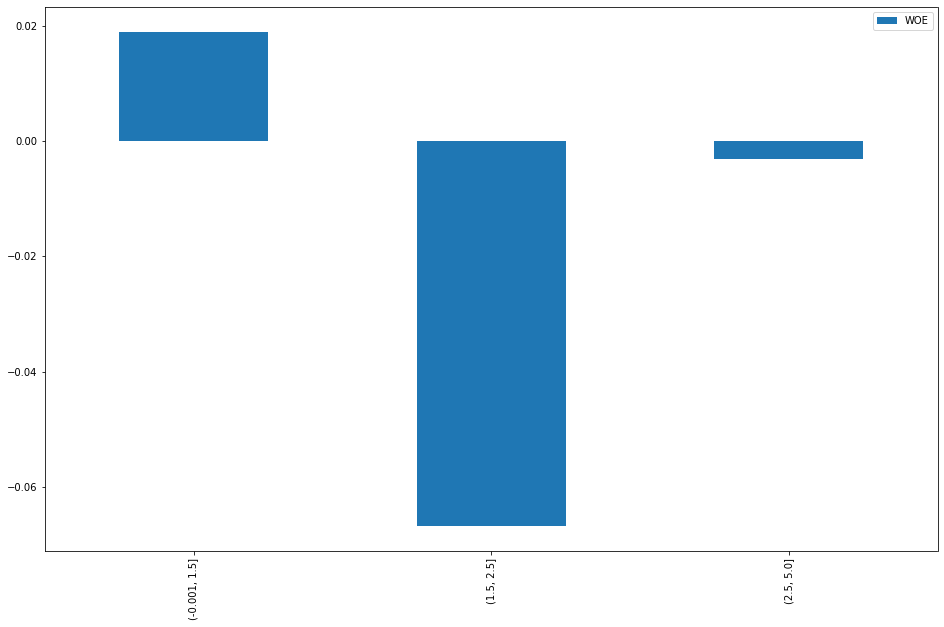

In [41]:
marr_1 = Segmen(new_, 'label', 'marriage')

In [42]:
marr_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 1.5]",6550,3306,3244,0.455938,0.460253,0.451622,0.0189,0.0002
1,"(1.5, 2.5]",1558,753,805,0.108451,0.104831,0.112070,-0.0668,0.0005
2,"(2.5, 5.0]",6258,3124,3134,0.435612,0.434916,0.436308,-0.0032,0.0000
3,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0007


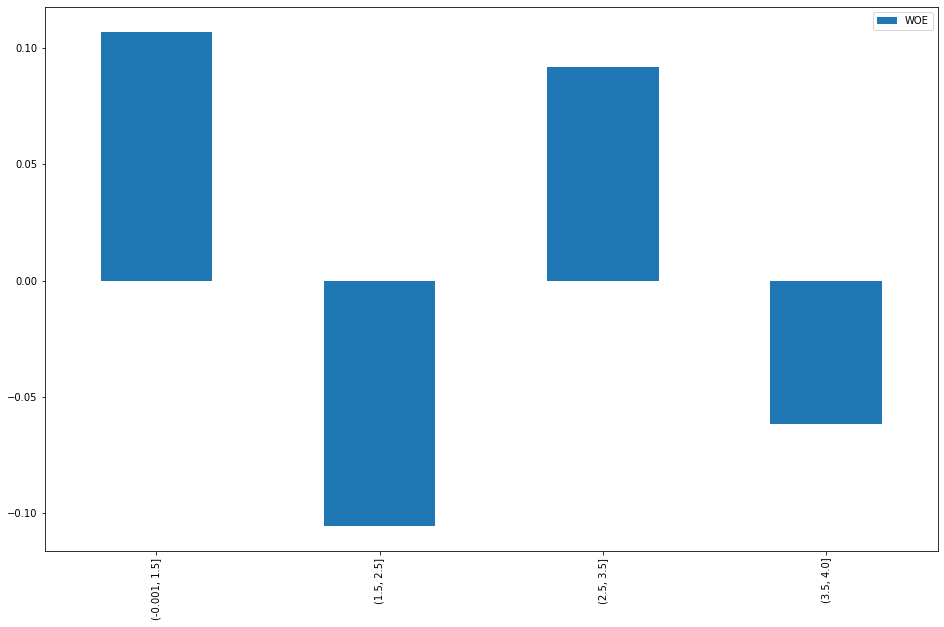

In [43]:
rpr_1 = Segmen(new_, 'label', 'RPR')

In [44]:
rpr_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 1.5]",4454,2346,2108,0.310038,0.326604,0.293471,0.1070,0.0035
1,"(1.5, 2.5]",4075,1930,2145,0.283656,0.268690,0.298622,-0.1056,0.0032
2,"(2.5, 3.5]",2050,1072,978,0.142698,0.149241,0.136155,0.0918,0.0012
3,"(3.5, 4.0]",3787,1835,1952,0.263609,0.255464,0.271753,-0.0618,0.0010
4,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0089


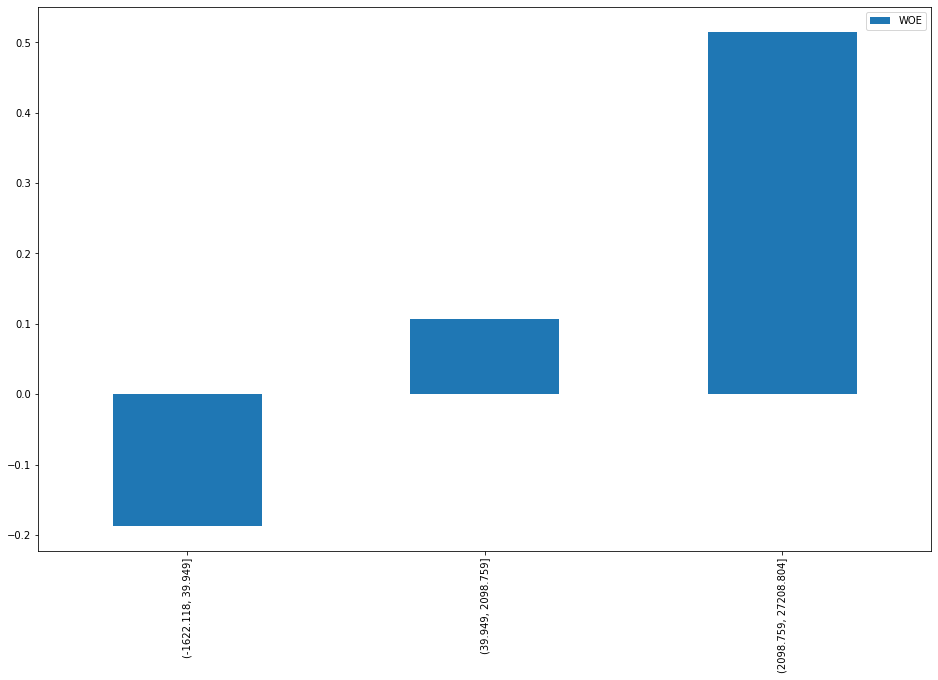

In [91]:
refund_1 = Segmen(new_, 'label', 'refund', p = 0.01)

In [92]:
refund_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-1622.118, 39.949]",5545,2514,3031,0.385981,0.349993,0.421969,-0.1870,0.0135
1,"(39.949, 2098.759]",8575,4515,4060,0.596895,0.628567,0.565223,0.1062,0.0067
2,"(2098.759, 27208.804]",246,154,92,0.017124,0.021440,0.012808,0.5152,0.0044
3,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0246


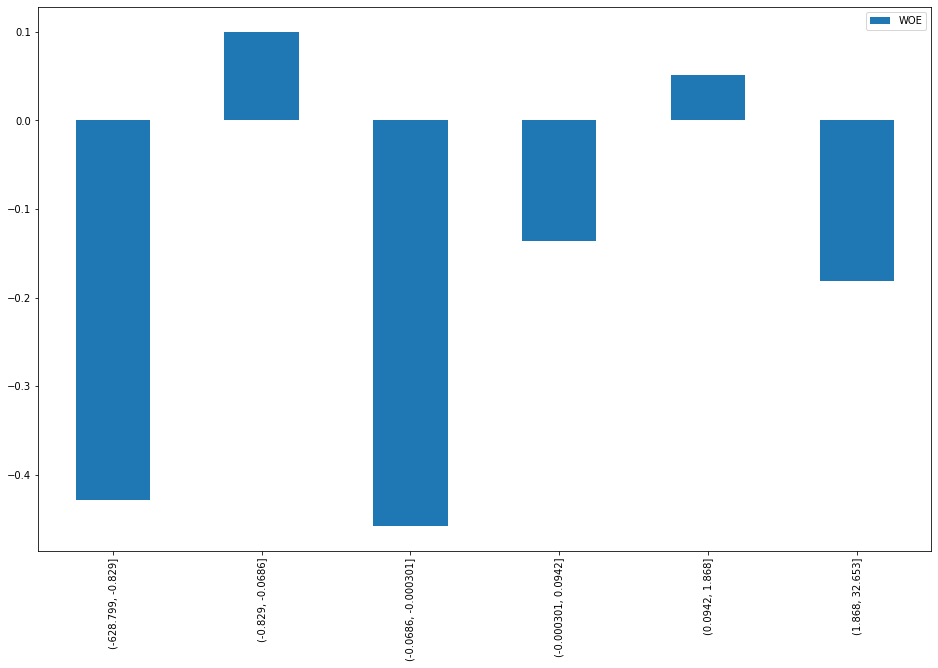

In [97]:
rate_1 = Segmen(new_, 'label', 'rate', p = 0.015)

In [98]:
rate_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-628.799, -0.829]",218,86,132,0.015175,0.011973,0.018377,-0.4285,0.0027
1,"(-0.829, -0.0686]",280,147,133,0.019490,0.020465,0.018516,0.1001,0.0002
2,"(-0.0686, -0.000301]",240,93,147,0.016706,0.012947,0.020465,-0.4578,0.0034
3,"(-0.000301, 0.0942]",650,303,347,0.045246,0.042183,0.048309,-0.1356,0.0008
4,"(0.0942, 1.868]",11217,5753,5464,0.780802,0.800919,0.760685,0.0515,0.0021
5,"(1.868, 32.653]",1761,801,960,0.122581,0.111513,0.133649,-0.1811,0.0040
6,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0132


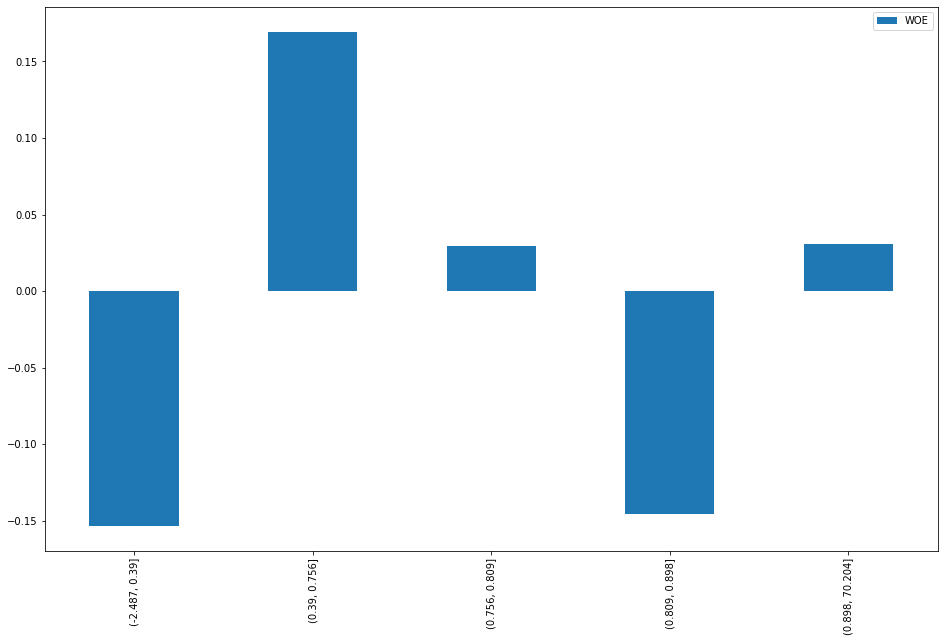

In [101]:
lrate_1 = Segmen(new_, 'label', 'limit_rate', p = 0.03)

In [102]:
lrate_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-2.487, 0.39]",2768,1278,1490,0.192677,0.177920,0.207434,-0.1535,0.0045
1,"(0.39, 0.756]",2816,1527,1289,0.196018,0.212585,0.179451,0.1694,0.0056
2,"(0.756, 0.809]",538,273,265,0.037450,0.038006,0.036893,0.0297,0.0000
3,"(0.809, 0.898]",1829,848,981,0.127314,0.118057,0.136572,-0.1457,0.0027
4,"(0.898, 70.204]",6415,3257,3158,0.446540,0.453432,0.439649,0.0309,0.0004
5,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0132


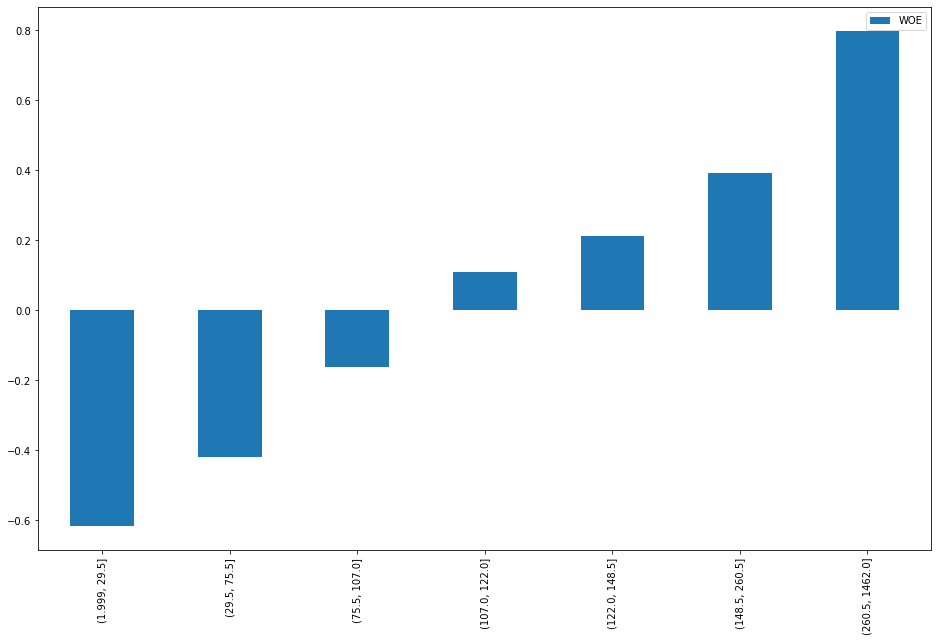

In [51]:
behav_1 = Segmen(new_, 'label', 'behav_data')

In [52]:
behav_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(1.999, 29.5]",2567,901,1666,0.178686,0.125435,0.231937,-0.6147,0.0655
1,"(29.5, 75.5]",2036,808,1228,0.141724,0.112488,0.170959,-0.4186,0.0245
2,"(75.5, 107.0]",2211,1016,1195,0.153905,0.141445,0.166365,-0.1623,0.0040
3,"(107.0, 122.0]",1763,930,833,0.122720,0.129472,0.115968,0.1102,0.0015
4,"(122.0, 148.5]",1552,858,694,0.108033,0.119449,0.096617,0.2121,0.0048
5,"(148.5, 260.5]",2699,1610,1089,0.187874,0.224140,0.151608,0.3910,0.0284
6,"(260.5, 1462.0]",1538,1060,478,0.107058,0.147571,0.066546,0.7964,0.0645
7,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.1932


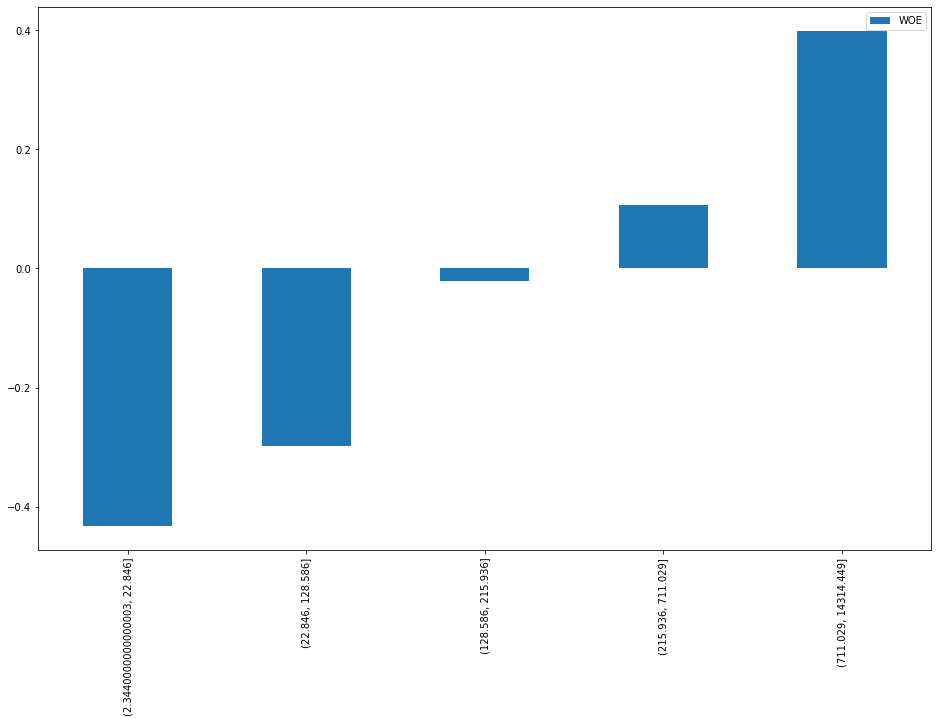

In [53]:
income_1 = Segmen(new_, 'label', 'Income_sum')

In [54]:
income_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(2.3440000000000003, 22.846]",2197,865,1332,0.152931,0.120423,0.185438,-0.4317,0.0281
1,"(22.846, 128.586]",2757,1175,1582,0.191911,0.163581,0.220242,-0.2974,0.0169
2,"(128.586, 215.936]",1613,798,815,0.112279,0.111096,0.113462,-0.0211,0.0000
3,"(215.936, 711.029]",4479,2359,2120,0.311778,0.328414,0.295141,0.1068,0.0036
4,"(711.029, 14314.449]",3320,1986,1334,0.231101,0.276486,0.185716,0.3979,0.0361
5,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0847


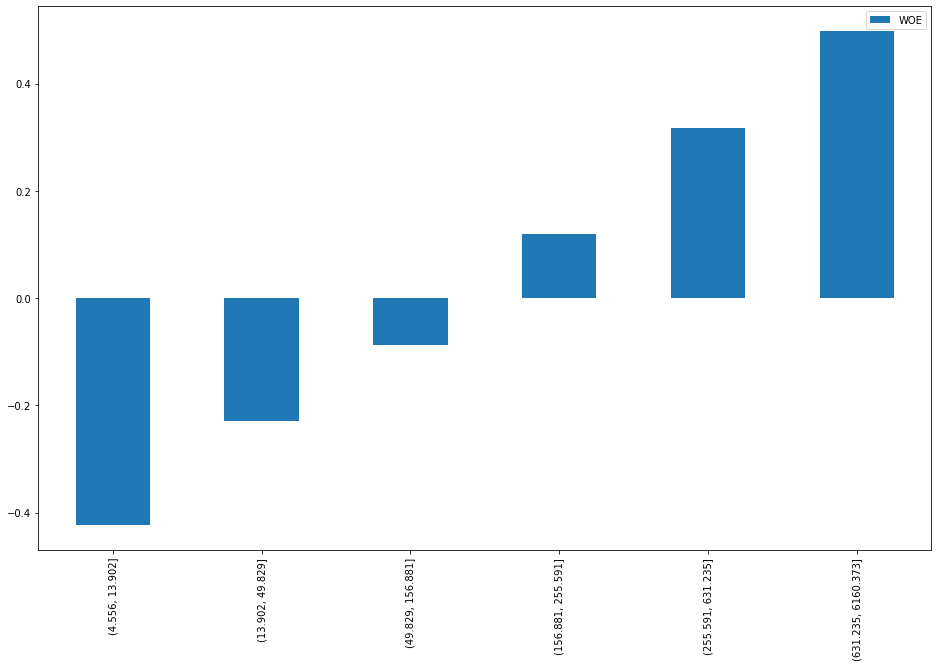

In [55]:
exp_1 = Segmen(new_, 'label', 'exp_sum')

In [56]:
exp_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(4.556, 13.902]",2540,1005,1535,0.176806,0.139914,0.213699,-0.4235,0.0312
1,"(13.902, 49.829]",3457,1532,1925,0.240638,0.213281,0.267994,-0.2284,0.0125
2,"(49.829, 156.881]",2059,985,1074,0.143325,0.137129,0.149520,-0.0865,0.0011
3,"(156.881, 255.591]",1447,767,680,0.100724,0.106780,0.094668,0.1204,0.0015
4,"(255.591, 631.235]",3035,1757,1278,0.211263,0.244605,0.177920,0.3183,0.0212
5,"(631.235, 6160.373]",1828,1137,691,0.127245,0.158290,0.096199,0.4980,0.0309
6,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0984


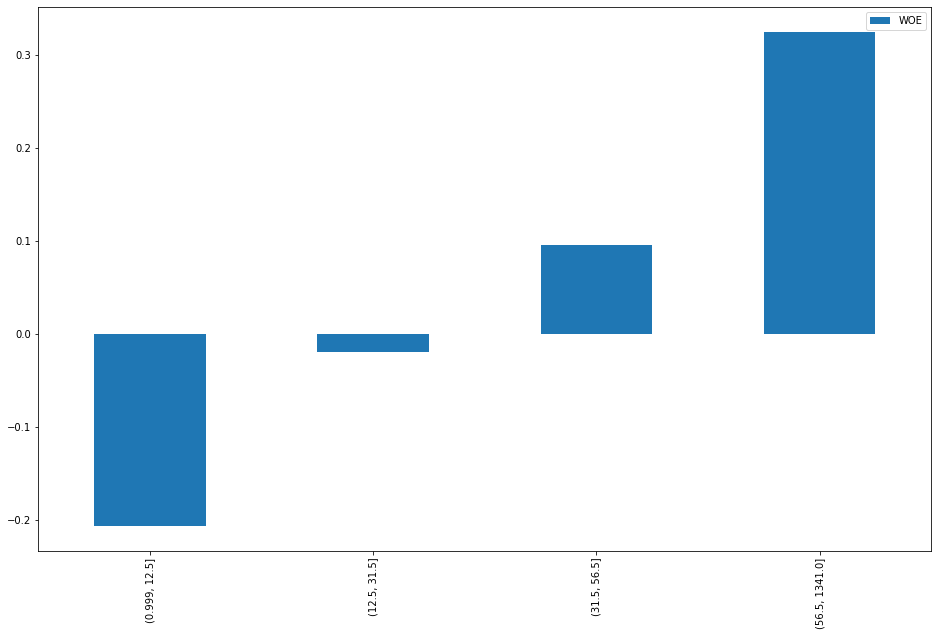

In [57]:
inmun = Segmen(new_, 'label', 'Income_mun')

In [58]:
inmun.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(0.999, 12.5]",6637,2977,3660,0.461994,0.414451,0.509536,-0.2065,0.0196
1,"(12.5, 31.5]",1598,791,807,0.111235,0.110121,0.112349,-0.0200,0.0000
2,"(31.5, 56.5]",2537,1329,1208,0.176598,0.185020,0.168175,0.0955,0.0016
3,"(56.5, 1341.0]",3594,2086,1508,0.250174,0.290408,0.209940,0.3245,0.0261
4,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0473


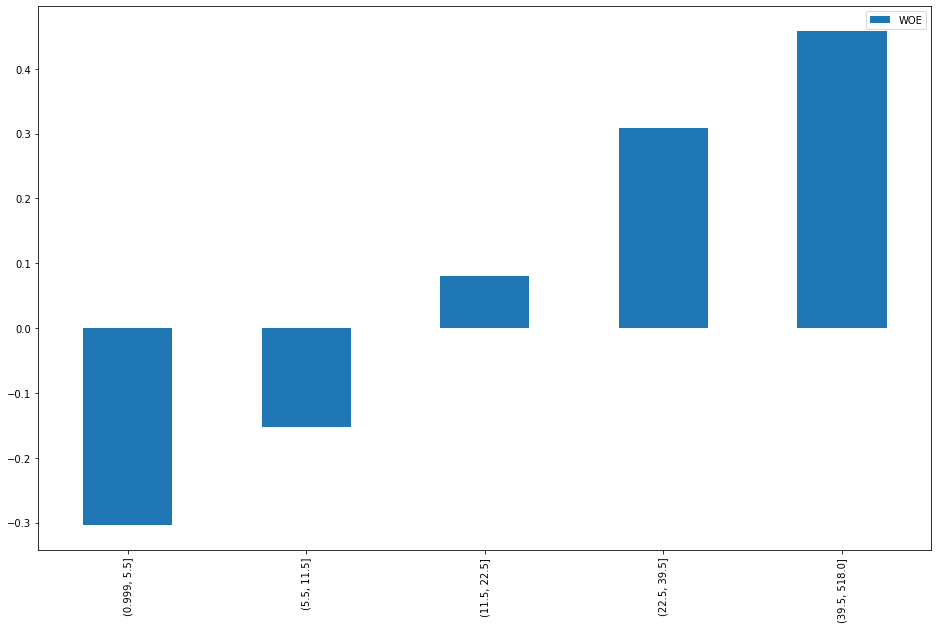

In [59]:
expmun = Segmen(new_, 'label', 'exp_mun')

In [60]:
expmun.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(0.999, 5.5]",4975,2112,2863,0.346304,0.294028,0.398580,-0.3042,0.0318
1,"(5.5, 11.5]",2384,1101,1283,0.165947,0.153279,0.178616,-0.1530,0.0039
2,"(11.5, 22.5]",2665,1386,1279,0.185507,0.192956,0.178059,0.0803,0.0012
3,"(22.5, 39.5]",2099,1210,889,0.146109,0.168453,0.123764,0.3083,0.0138
4,"(39.5, 518.0]",2243,1374,869,0.156133,0.191285,0.120980,0.4581,0.0322
5,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0829


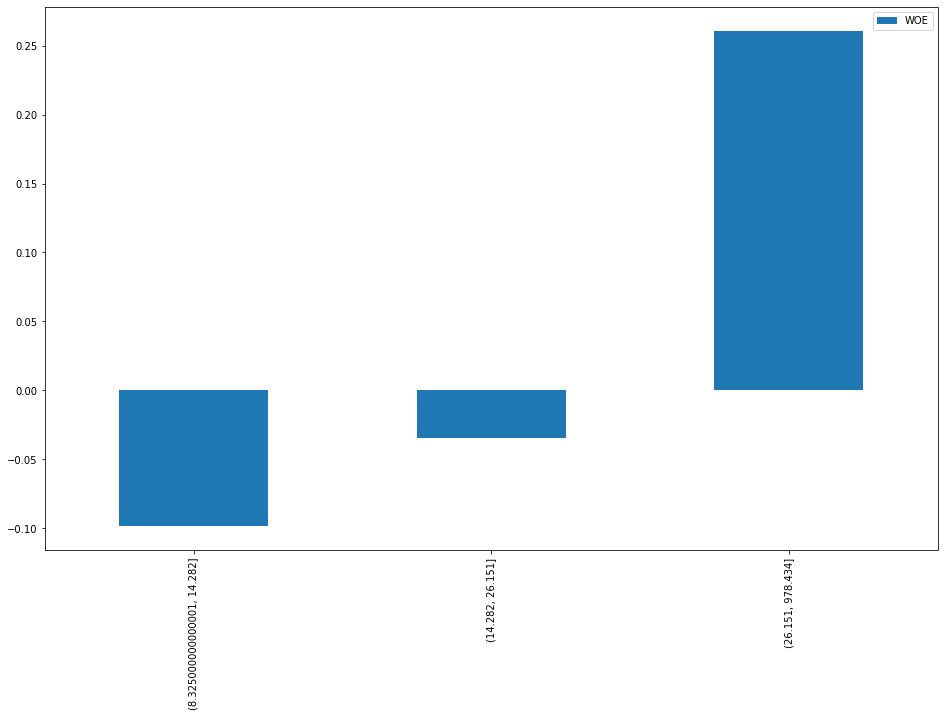

In [61]:
wage_1 = Segmen(new_, 'label', 'wage_sum', p = 0.15)

In [62]:
wage_1.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(8.325000000000001, 14.282]",5241,2492,2749,0.364820,0.346930,0.382709,-0.0982,0.0035
1,"(14.282, 26.151]",6306,3099,3207,0.438953,0.431435,0.446471,-0.0343,0.0005
2,"(26.151, 978.434]",2819,1592,1227,0.196227,0.221634,0.170820,0.2604,0.0132
3,Total,14366,7183,7183,1.000000,1.000000,1.000000,NaN,0.0172


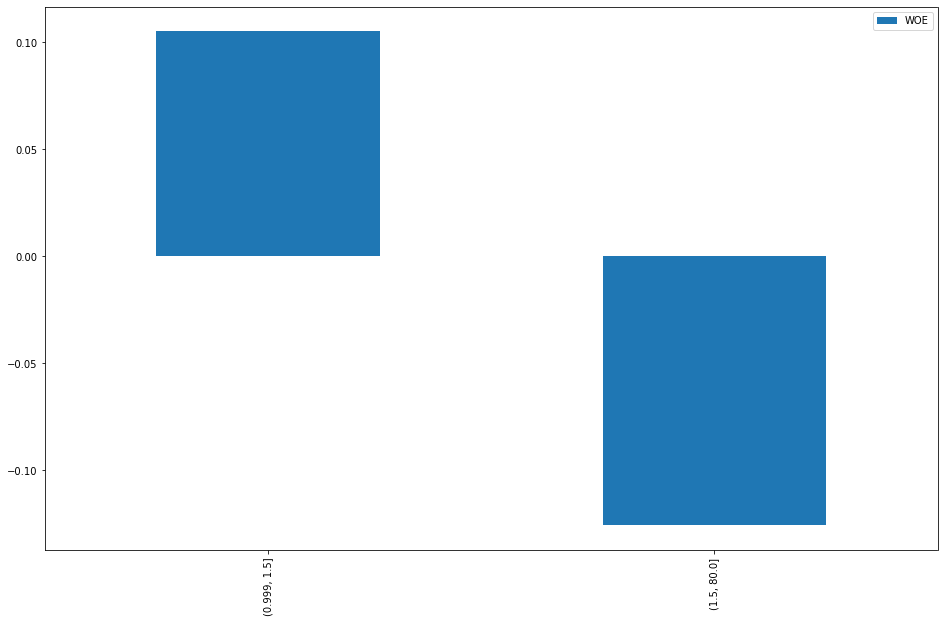

In [63]:
wagemun = Segmen(new_, 'label', 'wage_mun')

In [64]:
wagemun.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(0.999, 1.5]",7823,4117,3706,0.54455,0.573159,0.51594,0.1052,0.0060
1,"(1.5, 80.0]",6543,3066,3477,0.45545,0.426841,0.48406,-0.1258,0.0072
2,Total,14366,7183,7183,1.00000,1.000000,1.00000,NaN,0.0132


#### 查看所有特征的IV值
- 删除IV值小于0.02的特征

- IV < 0.02, 对预测几乎无帮助
- 0.02 $\leq$ IV < 0.1 具有一定帮助
- 0.1 $\leq$ IV < 0.3 对预测有较大帮助
- IV $\geq$ 0.3 具有很大帮助

In [103]:
iv_value = pd.Series({'sex': sex_1.IV, 'job': job_1.IV, 'education': edu_1.IV, 
                      'marriage': marr_1.IV, 'RPR': rpr_1.IV, 'refund': refund_1.IV, 
                      'rate': rate_1.IV, 'limit_rate': lrate_1.IV, 'behav_data': behav_1.IV, 
                      'Income_sum': income_1.IV, 'Income_mun': inmun.IV, 'exp_sum': exp_1.IV, 
                      'exp_mun': expmun.IV, 'wage_sum': wage_1.IV, 'wage_mun': wagemun.IV})

In [104]:
iv_value.sort_values(ascending=False)

behav_data    0.1932
exp_sum       0.0984
Income_sum    0.0847
exp_mun       0.0829
Income_mun    0.0473
refund        0.0246
sex           0.0214
wage_sum      0.0172
education     0.0152
wage_mun      0.0132
rate          0.0132
limit_rate    0.0132
RPR           0.0089
job           0.0027
marriage      0.0007
dtype: float64

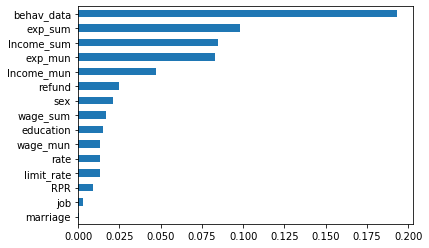

In [105]:
iv_value.sort_values().plot(kind="barh")

#### 生成WOE数据

In [120]:
df1 = new_.copy()
name_ = '_woe'

In [121]:
x_list1 = [income_1, behav_1, inmun, exp_1, refund_1, sex_1]
for i in x_list1:
    df1[i.Xname + name_] = i.Xbin.astype(str).replace(i.Dict)

In [122]:
df1.head()

,userID,sex,job,education,marriage,RPR,label,refund,rate,limit_rate,...,exp_sum,exp_mun,wage_sum,wage_mun,Income_sum_woe,behav_data_woe,Income_mun_woe,exp_sum_woe,refund_woe,sex_woe
0,38971,1,4,2,3,4,1,19.054980,-1.486348,1.000000,...,38.456591,2.0,15.357060,1.0,-0.4317,-0.4186,-0.2065,-0.2284,-0.1870,-0.0611
1,13845,1,4,4,3,2,1,0.000000,0.926522,0.000000,...,81.852818,3.0,13.756664,1.0,-0.4317,0.2121,-0.2065,-0.0865,-0.1870,-0.0611
2,19810,1,2,4,3,4,1,40.863655,0.172348,0.923659,...,12.147230,6.0,13.851974,2.0,-0.4317,-0.6147,-0.0200,-0.4235,0.1062,-0.0611
3,53452,1,2,3,1,4,1,0.000000,0.864075,0.970593,...,13.756664,3.0,58.402991,5.0,-0.0211,0.3910,-0.2065,-0.4235,-0.1870,-0.0611
4,10639,1,4,4,1,4,0,71.875468,1.011550,0.917343,...,385.897579,25.0,13.756664,1.0,0.1068,0.3910,0.0955,0.3183,0.1062,-0.0611


- 抽取WOE列作为预测数据X
- 加常数项列
- 抽取响应列作为Y

In [123]:
import scipy.stats as stats
import statsmodels.api as sm
X = df1.iloc[:, -len(x_list1):]
X = sm.add_constant(X)
y = df1.label

- 划分数据集

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=120)

#### 建模
- 建立逻辑回归模型,拟合数据,查看回归结果

In [125]:
glmodel = sm.GLM(y_train,X_train,family=sm.families.Binomial()).fit()
glmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  label   No. Observations:                10056
Model:                            GLM   Df Residuals:                    10049
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6489.4
Date:                Tue, 03 Dec 2019   Deviance:                       12979.
Time:                        10:10:49   Pearson chi2:                 1.01e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0165      0.021     -0.788      0.431      -0.058       0.025
Income_sum_woe    -1.7879      0.142    -12.553      0.000      -2.067      -1.509
behav_data_woe    -1.0743      0.049    -21.807      0.000      -1.171      -0.978
Income_mun_woe     1.3107      0.188      6.967      0.000       0.942       1.679
exp_sum_woe       -0.5615      0.071     -7.878      0.000      -0.701      -0.422
refund_woe        -0.7871      0.134     -5.886      0.000      -1.049      -0.525
sex_woe           -1.2218      0.144     -8.472      0.000      -1.504      -0.939
==================================================================================
"""

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### 查看共线性
- 计算每个特征的VIF值，查看是否共线

In [126]:
vif = [variance_inflation_factor(X_train.iloc[:,1:].values,i
                                 ) for i in range(X_train.shape[1]-1)]
print(pd.Series(dict(zip(X_train.columns[1:],vif))))

Income_sum_woe    3.917764
behav_data_woe    1.041735
Income_mun_woe    3.834179
exp_sum_woe       1.170083
refund_woe        1.003577
sex_woe           1.001667
dtype: float64


- Income_sum_woe和Income_mun_woe, 共线性不是很明显，其他特征没有共线

### 生成评分卡
- 根据逻辑回归模型和之前筛选得到的列表,给定参数,生成评分卡
- 调整参数,使得评分卡分数范围满足需求

In [76]:
def Score(logitmodel, xlist, pdo=20, score=720, odds=50):
    # relevant parameters.相关参数
    factor = pdo / np.log(2)
    offset = score - factor * np.log(odds)
    
    n = len(xlist)
    coef = logitmodel.params[1:]
    beta0 = logitmodel.params[0]
    Score = pd.DataFrame()
    j = 0
    
    # Score card table.评分卡表格
    for i in xlist:
        Score_i = pd.DataFrame({"Characteristic":i.Xname,
                                "Attribute":list(i.Dict.keys()),
                                "WOE":list(i.Dict.values()),
                                "Coef":coef[j]})
        j += 1
        Score = Score.append(Score_i)
    Score["Points"] = offset/n + factor * ( beta0/n + 
                      Score["Coef"] * Score["WOE"])
    Score["Points"] = Score["Points"].astype(int)
    
    # calculate max and min score.计算最高最低分
    ScoreMax = Score[["Characteristic","Points"]].groupby(
                "Characteristic",sort=False).max().sum()
    ScoreMin = Score[["Characteristic","Points"]].groupby(
                "Characteristic",sort=False).min().sum()
    
    minmaxscore = [*ScoreMin,*ScoreMax]
    
    out = pd.Series({"ScoreCard":Score.iloc[:,[0,1,4]],
                     "ScoreCardFull":Score,
                     "minmaxscore":minmaxscore,
                     "factor":factor,
                     "offset":offset})
    return out

In [127]:
scorecard = Score(glmodel,x_list1,pdo=30,score=800,odds=10)
scorecard.minmaxscore

[569, 797]

- 查看最终评分卡

In [128]:
scorecard.ScoreCard

,Characteristic,Attribute,Points
0,Income_sum,"(2.3440000000000003, 22.846]",150
1,Income_sum,"(22.846, 128.586]",139
2,Income_sum,"(128.586, 215.936]",118
3,Income_sum,"(215.936, 711.029]",108
4,Income_sum,"(711.029, 14314.449]",85
0,behav_data,"(1.999, 29.5]",145
1,behav_data,"(29.5, 75.5]",136
2,behav_data,"(75.5, 107.0]",124
3,behav_data,"(107.0, 122.0]",111
4,behav_data,"(122.0, 148.5]",106


#### 模型评估
- 根据之前的分卡对象得到测试集分数

In [79]:
def Score_Data(func, data):
    ncol = data.shape[1]
    name_append = "_woe"
    scorelist = list(func.ScoreCardFull.groupby(
                "Characteristic",sort=False))

    for i in scorelist:
        right = pd.DataFrame({i[0]+name_append:i[1]["WOE"],
                              i[0]+"_Score":i[1]["Points"]})
        data = pd.merge(data,right,how="left",on=i[0]+name_append)

    data["Score"] = data.iloc[:,ncol:].sum(axis=1)
    
    return data

In [129]:
testscore = Score_Data(scorecard,X_test)
testscore.head()

,const,Income_sum_woe,behav_data_woe,Income_mun_woe,exp_sum_woe,refund_woe,sex_woe,Income_sum_Score,behav_data_Score,Income_mun_Score,exp_sum_Score,refund_Score,sex_Score,Score
0,1.0,0.3979,0.1102,0.3245,0.3183,0.1062,-0.0611,85,111,135,108,112,119,670
1,1.0,0.3979,0.2121,0.3245,0.3183,0.1062,0.3497,85,106,135,108,112,98,644
2,1.0,-0.2974,-0.4186,-0.2065,-0.4235,0.1062,-0.0611,139,136,104,126,112,119,736
3,1.0,0.1068,0.7964,0.0955,0.4980,-0.1870,-0.0611,108,79,122,104,122,119,654
4,1.0,-0.4317,-0.4186,-0.2065,-0.2284,0.1062,-0.0611,150,136,104,122,112,119,743


- 通过测试集中真实的y,和预测的分数,绘制ks曲线
- 得到对应的最优阈值以及相关度量

In [81]:
def evaluate(y,score,index="acc",beta=1,plot=None,report=True):
    # sort score.分数排序
    eva = pd.DataFrame({"y":y.values,"Score":score.values})
    eva = eva.sort_values(by = "Score",ascending=False)
    eva.index = np.arange(eva.shape[0])
    
    # add characteristic.添加特征
    # positive.正例个数
    P = eva["y"].value_counts()[1]
    # negative.负例个数
    N = eva["y"].value_counts()[0]
    # all samples.总个数
    A = P + N
    # prevalence.流行率/患病率
    Prevalance = P / (P+N)
    # true positive.真正例
    eva["TP"] = eva["y"].cumsum()
    # false positive.假正例
    eva["FP"] = (-(eva["y"]-1)).cumsum()
    # false negative.假负例
    eva["FN"] = P - eva["TP"]
    # ture negative.正负例
    eva["TN"] = N - eva["FP"]
    # rate of positive predictions.预测为正例比例
    eva["rpp"] = [*(eva.index+1)]
    eva["rpp"] = eva["rpp"] / eva.shape[0]
    # true positive rate/sensitivity/recall.真阳性率/灵敏度/召回率
    eva["tpr"] = eva["TP"] / P
    # false positive rate/1-specificity.假阳性率/1-特异度
    eva["fpr"] = eva["FP"] / N
    # precision/positive predictive value.精确度
    eva["ppv"] = eva["TP"] / (eva["TP"] + eva["FP"])
    # accuracy.准确率
    eva["acc"] = (eva["TP"] + eva["TN"]) / A
    # F-measure.F统计量
    eva["f"] = ((1+beta**2)*eva["ppv"]*eva["tpr"]
                ) / (beta**2 *eva["ppv"]+eva["tpr"])
    # ks statistics.ks统计量
    eva["ks"] = eva["tpr"] - eva["fpr"]
    # lift value.lift指标
    eva["lift"] = eva["ppv"] / Prevalance
    
    # calculate auc value.计算auc值
    auc0 = eva[["tpr","fpr"]].copy()
    auc0["fpr_diff"] = auc0["fpr"].diff()
    auc0.at[0,"fpr_diff"] = auc0.at[0,"fpr"]
    auc0["area"] = auc0["fpr_diff"] * auc0["tpr"]
    auc = auc0["area"].sum()
    
    # calculate optimal cutoff for given index.计算给定指标的最优阈值
    optimal_cutoff = eva.loc[eva[index].idxmax()]
    optimal_cutoff = optimal_cutoff[1:]
    cutoff = optimal_cutoff.Score
    if report:
        print(f"The optimal cutoff(for {index}) is {optimal_cutoff.Score}")
        print(f"The maximum value of {index} is: {optimal_cutoff[index].round(4)}")
        print(optimal_cutoff)
    
    # plot roc curve.绘制ROC曲线
    if plot == "roc":
        plt.figure()
        plt.plot(eva["fpr"],eva["tpr"],label=f"Area Under Curve: {auc:.2f}")
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    # plot ks curve.绘制KS曲线
    if plot == "ks":
        kscut = eva.loc[eva["ks"].idxmax()]
        plt.figure()
        plt.plot(eva["rpp"],eva["tpr"],label = "True Positive Rate")
        plt.plot(eva["rpp"],eva["fpr"],label = "False Positive Rate")
        plt.plot([kscut["rpp"],kscut["rpp"]],[kscut["fpr"],kscut["tpr"]],"k--")
        plt.legend(loc="lower right")
        plt.text(kscut["rpp"]-0.24,kscut["fpr"]+kscut["ks"]/2,f"max ks:{kscut.ks.round(4)}")
        plt.xlabel('rate of positive predictions')
        plt.title('K-S curve')
        plt.show()
    
    out = pd.Series({"evatable":eva,"AUC":auc,"optimal_cutoff":optimal_cutoff,
                     "cutoff":cutoff})
    return out

The optimal cutoff(for ks) is 702.0
The maximum value of ks is: 0.261
Score     702.000000
TP       1213.000000
FP        631.000000
FN        965.000000
TN       1501.000000
rpp         0.427842
tpr         0.556933
fpr         0.295966
ppv         0.657809
acc         0.629698
f           0.603182
ks          0.260967
lift        1.301725
Name: 1843, dtype: float64


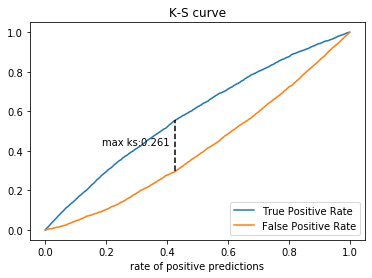

In [130]:
evaluate1 = evaluate(y_test,testscore["Score"],index="ks",plot="ks")

- 绘制ROC曲线

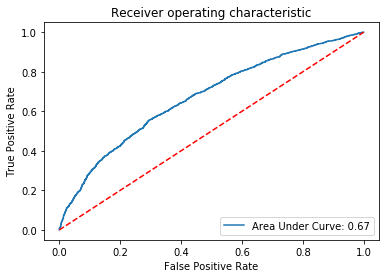

In [131]:
evaluate2 = evaluate(y_test,testscore["Score"],plot="roc",report=False)